In [1]:
%pip install torch matplotlib numpy tqdm

In [2]:
import torch
from torch import nn
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [6]:
from zipfile import ZipFile

def load_ptb_data(root_dir, which):
    """
    Arguments:
        root_dir (string): Directory containing the data files.
        which (string): "train", "test", or "val" dataset
    """
    d = {"train": 1, "test": 5, "val": 7}
    with ZipFile(root_dir, "r") as zip_ref:
        file_name = zip_ref.namelist()[d[which]]
        with zip_ref.open(file_name) as file:
            words = []
            for line in file:
                words += line.decode("utf-8").split()
                words += ["<eos>"]
            if which == "train":
              global word_to_index
              word_to_index = {word: idx for idx, word in enumerate(set(words))}
              global index_to_word
              index_to_word = {idx: word for idx, word in enumerate(set(words))}
            data = np.array([word_to_index[word] for word in words], dtype=np.int32)
            return data


train_set = load_ptb_data(root_dir="./drive/MyDrive/Colab Notebooks/ptb_data.zip", which="train")
test_set = load_ptb_data(root_dir="./drive/MyDrive/Colab Notebooks/ptb_data.zip", which="test")
val_set = load_ptb_data(root_dir="./drive/MyDrive/Colab Notebooks/ptb_data.zip", which="val")

x = val_set[:20]
[index_to_word[i] for i in x]

['consumers',
 'may',
 'want',
 'to',
 'move',
 'their',
 'telephones',
 'a',
 'little',
 'closer',
 'to',
 'the',
 'tv',
 'set',
 '<eos>',
 '<unk>',
 '<unk>',
 'watching',
 'abc',
 "'s"]

In [7]:
assert (len(index_to_word)) == (max(train_set)+1) == (max(val_set)+1)

In [53]:
from tqdm.notebook import tqdm
import math

hidden_dim = 200
seq_len = 20
batch_size = 20

def initialize_weights(model):
    for name, param in model.named_parameters():
        if "weight" in name:
            nn.init.uniform_(param, -0.1, 0.1)
        elif "bias" in name:
            nn.init.zeros_(param)


def train(model, train_set, val_set, loss_fn, optimizer, epochs=15, gru=False):
    # initialize_weights(model)

    perplexities = []
    test_perplexities = []

    try:
        # move data to GPU
        train_set = torch.tensor(train_set).to(device)
        val_set = torch.tensor(val_set).to(device)

        for epoch in tqdm(range(epochs)):
            print(f"Epoch: {epoch}")

            if epoch > 4:
                # reduce learning rate
                for g in optimizer.param_groups:
                    g["lr"] *= 0.5

            model.train()
            train_loss = train_epoch(model, train_set, loss_fn, optimizer, gru)
            train_perplexity = math.exp(train_loss)
            perplexities.append(train_perplexity)
            print(f"Train Perplexity: {train_perplexity:.4f}")

            model.eval()
            val_loss = evaluate(model, val_set, loss_fn, gru)
            val_perplexity = math.exp(val_loss)
            test_perplexities.append(val_perplexity)
            print(f"Val Perplexity: {val_perplexity:.4f}")

    except KeyboardInterrupt:
        print("Exiting...")

    return perplexities, test_perplexities

def train_epoch(model, dataset, loss_fn, optimizer, gru):
    total_loss = 0
    count = 0
    data_ptr = 0

    hn = torch.zeros((2, batch_size, hidden_dim)).to(device)
    if not gru:
        cn = torch.zeros((2, batch_size, hidden_dim)).to(device)

    while data_ptr + seq_len * batch_size + 1 <= len(dataset):
        optimizer.zero_grad()

        data_chunk = dataset[data_ptr:data_ptr + seq_len*batch_size].reshape((batch_size, seq_len))
        target = dataset[data_ptr+1:data_ptr+1+seq_len*batch_size].reshape((batch_size, seq_len))

        if gru:
            outputs, hn = model(data_chunk, hn.detach())
        else:
            outputs, (hn, cn) = model(data_chunk, (hn.detach(), cn.detach()))
        loss = loss_fn(outputs.transpose(1, 2), target.long())

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        optimizer.step()

        total_loss += loss.item()
        count += 1
        data_ptr += seq_len * batch_size

    return total_loss / count

def evaluate(model, dataset, loss_fn, gru):
    total_loss = 0
    count = 0
    data_ptr = 0

    hn = torch.zeros((2, batch_size, hidden_dim)).to(device)
    if not gru:
        cn = torch.zeros((2, batch_size, hidden_dim)).to(device)

    with torch.no_grad():
        while data_ptr + seq_len * batch_size + 1 <= len(dataset):
            data_chunk = dataset[data_ptr:data_ptr + seq_len*batch_size].reshape((batch_size, seq_len))
            target = dataset[data_ptr+1:data_ptr+1+seq_len*batch_size].reshape((batch_size, seq_len))

            if gru:
                outputs, hn = model(data_chunk, hn.detach())
            else:
                outputs, (hn, cn) = model(data_chunk, (hn, cn))
            loss = loss_fn(outputs.transpose(1, 2), target.long())

            total_loss += loss.item()
            count += 1
            data_ptr += seq_len * batch_size

    return total_loss / count

In [28]:
def test(model, test_set, loss_fn, gru=False):
    total_loss = 0
    count = 0
    data_ptr = 0

    model.eval()

    test_set = torch.tensor(test_set).to(device)

    with torch.no_grad():
        hn = torch.zeros((2, batch_size, hidden_dim)).to(device)
        if not gru:
            cn = torch.zeros((2, batch_size, hidden_dim)).to(device)

        while data_ptr + seq_len * batch_size + 1 <= len(test_set):
            data_chunk = test_set[data_ptr:data_ptr + seq_len*batch_size].reshape((batch_size, seq_len))
            target = test_set[data_ptr+1:data_ptr+1+seq_len*batch_size].reshape((batch_size, seq_len))

            if gru:
                outputs, hn = model(data_chunk, hn.detach())
            else:
                outputs, (hn, cn) = model(data_chunk, (hn.detach(), cn.detach()))
            total_loss += loss_fn(outputs.transpose(1, 2), target.long())

            count += 1
            data_ptr += seq_len*batch_size

        test_perplexity = math.exp(total_loss / count)
        print(f"Test Perplexity: {test_perplexity:.4}")


In [43]:
class LSTM(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=2, batch_first=True)
        self.linear = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x, hidden_state):
        embeds = self.embedding(x)
        out, (hn, cn) = self.lstm(embeds, hidden_state)
        out = self.linear(out)
        return out, (hn, cn)


In [54]:
net = LSTM(200, 200, len(index_to_word))
net.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=2)
perplexities, test_perplexities = train(net, train_set, val_set, loss_fn, optimizer)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 0
Train Perplexity: 430.6701
Val Perplexity: 279.8416
Epoch: 1
Train Perplexity: 229.1221
Val Perplexity: 213.7598
Epoch: 2
Train Perplexity: 176.7413
Val Perplexity: 189.0534
Epoch: 3
Train Perplexity: 148.7746
Val Perplexity: 177.0664
Epoch: 4
Train Perplexity: 130.5357
Val Perplexity: 170.4979
Epoch: 5
Train Perplexity: 110.1650
Val Perplexity: 163.5219
Epoch: 6
Train Perplexity: 99.3526
Val Perplexity: 160.1635
Epoch: 7
Train Perplexity: 93.6955
Val Perplexity: 158.3993
Epoch: 8
Train Perplexity: 90.7012
Val Perplexity: 157.4920
Epoch: 9
Train Perplexity: 89.0948
Val Perplexity: 157.0349
Epoch: 10
Train Perplexity: 88.2139
Val Perplexity: 156.8537
Epoch: 11
Train Perplexity: 87.7273
Val Perplexity: 156.7723
Epoch: 12
Train Perplexity: 87.4615
Val Perplexity: 156.7203
Epoch: 13
Train Perplexity: 87.3186
Val Perplexity: 156.6962
Epoch: 14
Train Perplexity: 87.2438
Val Perplexity: 156.6874


In [55]:
test(net, test_set, loss_fn)

Test Perplexity: 149.4


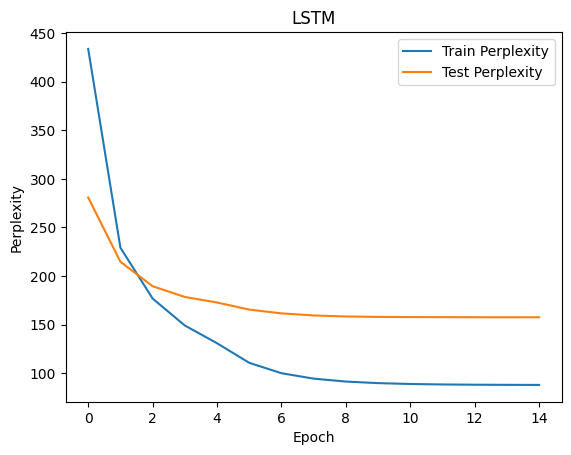

In [46]:
plt.plot(perplexities, label="Train Perplexity")
plt.plot(test_perplexities, label="Test Perplexity")
plt.xlabel("Epoch")
plt.ylabel("Perplexity")
plt.title("LSTM")
plt.legend()
plt.show()

In [11]:
class DropoutLSTM(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=2, batch_first=True, dropout=0.25)
        self.drouput = nn.Dropout(0.25)
        self.linear = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x, hidden_state):
        embeds = self.embedding(x)
        out, (hn, cn) = self.lstm(embeds, hidden_state)
        out = self.drouput(out)
        out = self.linear(out)
        return out, (hn, cn)

In [34]:
dropout_net = DropoutLSTM(200, 200, len(index_to_word))
dropout_net.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(dropout_net.parameters(), lr=2)
dropout_perplexities, dropout_test_perplexities = train(dropout_net, train_set, val_set, loss_fn, optimizer)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 0
Train Perplexity: 452.4327
Val Perplexity: 287.0488
Epoch: 1
Train Perplexity: 259.3448
Val Perplexity: 220.8611
Epoch: 2
Train Perplexity: 210.8658
Val Perplexity: 194.5108
Epoch: 3
Train Perplexity: 185.2005
Val Perplexity: 178.9751
Epoch: 4
Train Perplexity: 168.3933
Val Perplexity: 169.2314
Epoch: 5
Train Perplexity: 150.3392
Val Perplexity: 159.7329
Epoch: 6
Train Perplexity: 140.8286
Val Perplexity: 154.9548
Epoch: 7
Train Perplexity: 135.9991
Val Perplexity: 152.6498
Epoch: 8
Train Perplexity: 133.5742
Val Perplexity: 151.5769
Epoch: 9
Train Perplexity: 132.0299
Val Perplexity: 151.1221
Epoch: 10
Train Perplexity: 131.2083
Val Perplexity: 150.9729
Epoch: 11
Train Perplexity: 131.0813
Val Perplexity: 150.8738
Epoch: 12
Train Perplexity: 130.7162
Val Perplexity: 150.8181
Epoch: 13
Train Perplexity: 130.6899
Val Perplexity: 150.7942
Epoch: 14
Train Perplexity: 130.6155
Val Perplexity: 150.7874


In [35]:
test(dropout_net, test_set, loss_fn)

Test Perplexity: 144.2


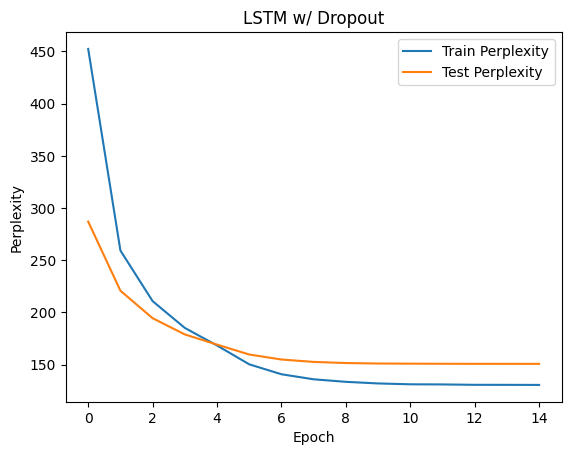

In [47]:
plt.plot(dropout_perplexities, label="Train Perplexity")
plt.plot(dropout_test_perplexities, label="Test Perplexity")
plt.xlabel("Epoch")
plt.ylabel("Perplexity")
plt.title("LSTM w/ Dropout")
plt.legend()
plt.show()

In [33]:
class GRU(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers=2, batch_first=True)
        self.linear = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x, hidden_state):
        embeds = self.embedding(x)
        out, hn = self.gru(embeds, hidden_state)
        out = self.linear(out)
        return out, hn


In [25]:
gru_net = GRU(200, 200, len(index_to_word))
gru_net.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(gru_net.parameters(), lr=1)
gru_perplexities, gru_test_perplexities = train(gru_net, train_set, val_set, loss_fn, optimizer, gru=True)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 0
Train Perplexity: 362.7990
Val Perplexity: 248.4615
Epoch: 1
Train Perplexity: 203.4056
Val Perplexity: 203.4564
Epoch: 2
Train Perplexity: 162.3650
Val Perplexity: 187.3336
Epoch: 3
Train Perplexity: 139.1923
Val Perplexity: 180.7643
Epoch: 4
Train Perplexity: 123.3833
Val Perplexity: 178.6645
Epoch: 5
Train Perplexity: 103.9549
Val Perplexity: 169.9746
Epoch: 6
Train Perplexity: 94.1734
Val Perplexity: 165.8252
Epoch: 7
Train Perplexity: 89.0829
Val Perplexity: 163.8250
Epoch: 8
Train Perplexity: 86.3334
Val Perplexity: 162.9302
Epoch: 9
Train Perplexity: 84.8229
Val Perplexity: 162.5640
Epoch: 10
Train Perplexity: 83.9997
Val Perplexity: 162.4076
Epoch: 11
Train Perplexity: 83.5592
Val Perplexity: 162.3493
Epoch: 12
Train Perplexity: 83.3279
Val Perplexity: 162.3349
Epoch: 13
Train Perplexity: 83.2082
Val Perplexity: 162.3343
Epoch: 14
Train Perplexity: 83.1469
Val Perplexity: 162.3362


In [30]:
test(gru_net, test_set, loss_fn, gru=True)

Test Perplexity: 154.3


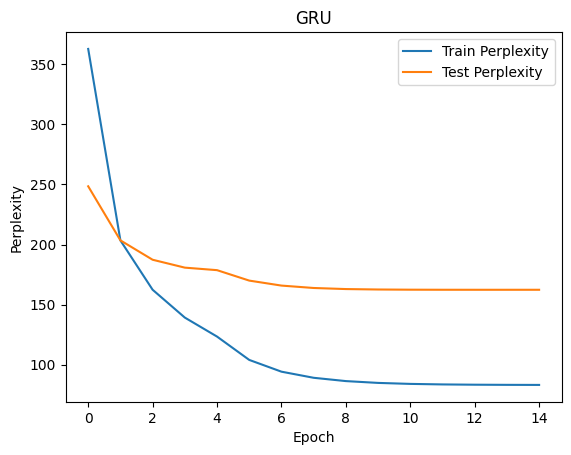

In [48]:
plt.plot(gru_perplexities, label="Train Perplexity")
plt.plot(gru_test_perplexities, label="Test Perplexity")
plt.xlabel("Epoch")
plt.ylabel("Perplexity")
plt.title("GRU")
plt.legend()
plt.show()

In [38]:
class DropoutGRU(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers=2, batch_first=True, dropout=0.25)
        self.dropout = nn.Dropout(0.25)
        self.linear = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x, hidden_state):
        embeds = self.embedding(x)
        out, hn = self.gru(embeds, hidden_state)
        out = self.dropout(out)
        out = self.linear(out)
        return out, hn


In [39]:
dropout_gru_net = DropoutGRU(200, 200, len(index_to_word))
dropout_gru_net.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(dropout_gru_net.parameters(), lr=1)
dropout_gru_perplexities, dropout_gru_test_perplexities = train(dropout_gru_net, train_set, val_set, loss_fn, optimizer, gru=True)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 0
Train Perplexity: 406.4415
Val Perplexity: 260.1604
Epoch: 1
Train Perplexity: 247.4064
Val Perplexity: 213.5053
Epoch: 2
Train Perplexity: 208.0483
Val Perplexity: 194.1687
Epoch: 3
Train Perplexity: 186.6074
Val Perplexity: 183.0188
Epoch: 4
Train Perplexity: 172.4827
Val Perplexity: 175.9395
Epoch: 5
Train Perplexity: 153.5518
Val Perplexity: 165.5117
Epoch: 6
Train Perplexity: 143.8797
Val Perplexity: 160.6550
Epoch: 7
Train Perplexity: 138.7225
Val Perplexity: 158.4873
Epoch: 8
Train Perplexity: 136.1476
Val Perplexity: 157.5034
Epoch: 9
Train Perplexity: 134.8843
Val Perplexity: 157.0742
Epoch: 10
Train Perplexity: 134.2775
Val Perplexity: 156.8735
Epoch: 11
Train Perplexity: 133.7833
Val Perplexity: 156.8137
Epoch: 12
Train Perplexity: 133.5924
Val Perplexity: 156.7908
Epoch: 13
Train Perplexity: 133.5016
Val Perplexity: 156.7700
Epoch: 14
Train Perplexity: 133.6009
Val Perplexity: 156.7546


In [40]:
test(dropout_gru_net, test_set, loss_fn, gru=True)

Test Perplexity: 149.4


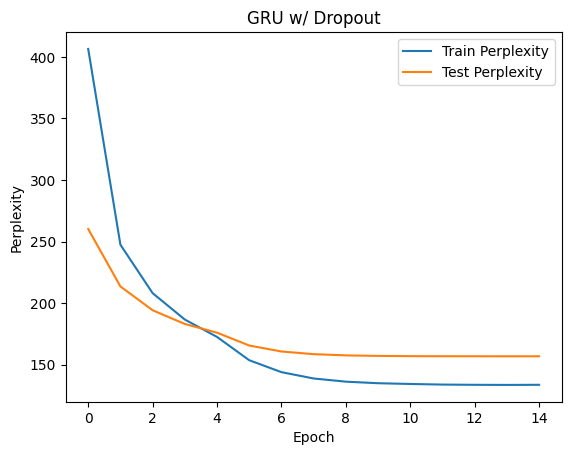

In [49]:
plt.plot(dropout_gru_perplexities, label="Train Perplexity")
plt.plot(dropout_gru_test_perplexities, label="Test Perplexity")
plt.xlabel("Epoch")
plt.ylabel("Perplexity")
plt.title("GRU w/ Dropout")
plt.legend()
plt.show()